In [67]:
import numpy as np
import matplotlib.pyplot as plt
from NumOpt.OptimizationProblem import OptimizationProblem
from NumOpt.post_processing import plot_histories

PROBLEM PARAMETERS

In [ ]:
rho = 7800
L = 0.5
Sy = 300e6
E = 210e9
F = 120e3

tmin = 0.001
tmax = 0.01

Rmin = 0.005
Rmax = 0.04


In [69]:
2*np.pi*Rmin*tmin*Sy

9424.777960769381

PLOT OF OBJECTIVE AND CONSTRAINTS

In [70]:
def total_mass(x, *args):
    R = x[0]
    t = x[1]
    mass = 2*np.pi*R*t*rho
    return mass

def yield_constraint(x, *args):
    R = x[0]
    t = x[1]
    const = F / (2*np.pi*R*t) - Sy
    return const

def buckling_constraint(x, *args):
    R = x[0]
    t = x[1]
    stress = F - np.pi**3 * E * R**3 * t / (4*L**2)
    return stress

def solution_both_active():
    R = 2 * L / np.pi * np.sqrt(2 * Sy / E)
    t = F / (4 * Sy * L) * np.sqrt(E / 2 / Sy)
    return R, t

In [71]:
ni, nj = 100, 100

radius = np.linspace(Rmin, Rmax, ni)
thickness = np.linspace(tmin, tmax, nj)

RAD, THK = np.meshgrid(radius, thickness, indexing='ij')

objFunc = np.zeros((ni, nj))
yieldConst = np.zeros((ni, nj))
bucklConst = np.zeros((ni, nj))

for i in range(ni):
    for j in range(nj):
        objFunc[i, j] = total_mass([RAD[i, j], THK[i, j]], None)
        yieldConst[i, j] = yield_constraint([RAD[i, j], THK[i, j]], None)
        bucklConst[i, j] = buckling_constraint([RAD[i, j], THK[i, j]], None)

Text(0, 0.5, '$t$ [m]')

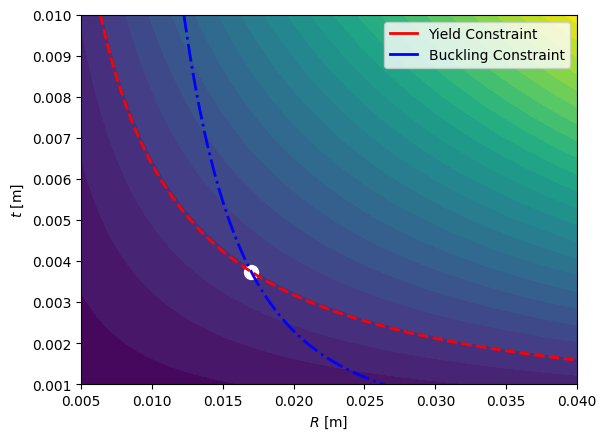

In [73]:
import matplotlib.lines as mlines



plt.figure()
plt.contourf(RAD, THK, objFunc, levels=30)

# Contours
c_yield   = plt.contour(RAD, THK, yieldConst, levels=[0], colors='r', linewidths=2, linestyles='--')
c_buckling = plt.contour(RAD, THK, bucklConst, levels=[0], colors='b', linewidths=2, linestyles='-.')

rmin, tmin = solution_both_active()
plt.scatter(rmin, tmin, marker='o', color='w', s=100, label='Optimal design')

# Proxy artists for legend
yield_proxy = mlines.Line2D([], [], color='r', linewidth=2, label='Yield Constraint')
buckl_proxy = mlines.Line2D([], [], color='b', linewidth=2, label='Buckling Constraint')

plt.legend(handles=[yield_proxy, buckl_proxy])

plt.xlabel(r'$R$ [m]')
plt.ylabel(r'$t$ [m]')


### CONSIDERATIONS

The white dot is the KKT solution option considering both constraints active. It is also the real KKT solution, because if we followed one of the contraints towards
function decrease, we would violate the other constraint. The white point is therefore the optimal minimum for this problem